
# Importing Packages

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00


In [ ]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from urllib.parse import quote_plus # to handle the special characters in the password

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, accuracy_score

import shap

import warnings
warnings.filterwarnings("ignore")

# Data Extraction

In [ ]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 16.7 MB/s eta 0:00:00


In [ ]:
host= "18.136.157.135"
user= "dm_team"
password= quote_plus("DM!$Team@&27920!")
database= "project_itsm"

engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}')

In [ ]:
tables = pd.read_sql_query('SHOW TABLES;', engine)
tables

,Tables_in_project_itsm
0,dataset_list


In [ ]:
print(pd.read_sql("describe dataset_list;", engine))

                         Field          Type Null Key Default Extra
0                      CI_Name  varchar(255)  YES        None      
1                       CI_Cat  varchar(255)  YES        None      
2                    CI_Subcat  varchar(255)  YES        None      
3                          WBS  varchar(255)  YES        None      
4                  Incident_ID  varchar(255)  YES        None      
5                       Status  varchar(255)  YES        None      
6                       Impact  varchar(255)  YES        None      
7                      Urgency  varchar(255)  YES        None      
8                     Priority  varchar(255)  YES        None      
9                   number_cnt  varchar(255)  YES        None      
10                    Category  varchar(255)  YES        None      
11                   KB_number  varchar(255)  YES        None      
12                Alert_Status  varchar(255)  YES        None      
13         No_of_Reassignments  varchar(255)  YE

In [ ]:
df = pd.read_sql("select * from dataset_list;", engine)
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,...,,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,,
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,...,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,,
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,...,,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,,,
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,...,,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,,,
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,...,,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,,,


In [ ]:
df.shape

(46606, 25)


Saving a copy

In [ ]:
df_raw = df.copy()
df_raw.to_csv("raw_data.csv", index=False)

# Checking for anomalies and handling them

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   CI_Name                     46606 non-null  object
 1   CI_Cat                      46606 non-null  object
 2   CI_Subcat                   46606 non-null  object
 3   WBS                         46606 non-null  object
 4   Incident_ID                 46606 non-null  object
 5   Status                      46606 non-null  object
 6   Impact                      46606 non-null  object
 7   Urgency                     46606 non-null  object
 8   Priority                    46606 non-null  object
 9   number_cnt                  46606 non-null  object
 10  Category                    46606 non-null  object
 11  KB_number                   46606 non-null  object
 12  Alert_Status                46606 non-null  object
 13  No_of_Reassignments         46606 non-null  ob

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
pd.set_option('display.max_columns', None)
df.sample(5)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
28545,DTA000057,application,Desktop Application,WBS000094,IM0028820,Closed,5,5,5,0.026099235,incident,KM0001205,closed,0,16-01-2014 17:20,,21-01-2014 14:31,21-01-2014 14:31,"2,07,44,44,444",No error - works as designed,1,SD0087001,,,
23733,WBA000124,application,Web Based Application,WBS000088,IM0023983,Closed,4,4,4,0.768654355,incident,KM0000611,closed,4,24-12-2013 11:49,,03-01-2014 11:00,03-01-2014 11:00,"5,16,79,44,444",Software,1,SD0071429,,,
44146,SBA000662,application,Server Based Application,WBS000071,IM0044543,Closed,3,3,3,0.949468447,incident,KM0001067,closed,2,18-03-2014 18:37,,26-03-2014 14:43,26-03-2014 14:43,"7,66,41,66,667",Software,1,SD0137290,,,
26567,SUB000456,subapplication,Web Based Application,WBS000073,IM0026836,Closed,4,4,4,0.879108293,incident,KM0001736,closed,0,09-01-2014 12:14,,09-01-2014 14:36,09-01-2014 14:36,"2,355",User error,1,SD0080596,,,
23617,ZOC000002,computer,zOS Cluster,WBS000199,IM0023867,Closed,3,3,3,0.666922838,incident,KM0000940,closed,0,24-12-2013 09:16,,24-12-2013 09:28,24-12-2013 09:28,"0,215833333",User error,1,SD0071168,,,


In [ ]:
# checking for anomalies
for col in df.columns:
  print(df[col].value_counts())
  print()

CI_Name
SUB000456    3050
SBA000263    2176
SBA000607    1743
SBA000462    1698
WBA000058    1614
             ... 
HMD000018       1
CBD000893       1
RTR000027       1
CBD000870       1
DSK000330       1
Name: count, Length: 3019, dtype: int64

CI_Cat
application             32900
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
                          111
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: count, dtype: int64

CI_Subcat
Server Based Application           18811
Web Based Application              15311
Desktop Application                 3876
Laptop                              1921
SAP                                 1199
                                   ...  
Windows Server in extern beheer        1
Virtual Tape Server             

As we can see there are many anomalies like `''`, `#MULTIVALUE` and `#N/B` values in most of the columns, so we'll now fetch the columns and their anomalies.

In [ ]:
anomaly_summary = []

for col in df.columns:
  s = df[col]

  s_str = s.astype(str)

  anomaly_summary.append({
        "column": col,
        "dtype": s.dtype,
        "null_count": s.isna().sum(),
        "empty_string_count": (s_str == "").sum(),
        "multivalue_count": (s_str == "#MULTIVALUE").sum(),
        "n/b_count": (s_str == "#N/B").sum(),
        "special_char_count": s_str.str.contains(r"[#?*]", regex=True).sum(),
        "unique_values": s.nunique(dropna=True)
        })

anomaly_df = pd.DataFrame(anomaly_summary)
anomaly_df.sort_values(
    ['multivalue_count', 'empty_string_count', 'null_count'],
    ascending=False
)


,column,dtype,null_count,empty_string_count,multivalue_count,n/b_count,special_char_count,unique_values
21,Related_Interaction,object,0,0,3434,114,3548,43060
24,Related_Change,object,0,46046,24,0,24,233
23,No_of_Related_Changes,object,0,46046,0,0,0,5
22,No_of_Related_Incidents,object,0,45384,0,0,0,25
15,Reopen_Time,object,0,44322,0,0,0,2245
16,Resolved_Time,object,0,1780,0,0,0,33628
19,Closure_Code,object,0,460,0,0,0,15
20,No_of_Related_Interactions,object,0,114,0,0,0,50
1,CI_Cat,object,0,111,0,0,0,13
2,CI_Subcat,object,0,111,0,0,0,65


In [ ]:
# displaying columns with `#MULTIVALUE` and empty string
anomaly_df[(anomaly_df['multivalue_count'] > 0) | (anomaly_df['empty_string_count'] > 0)].sort_values(
    ['multivalue_count', 'empty_string_count', 'null_count'],
    ascending=False
)

,column,dtype,null_count,empty_string_count,multivalue_count,n/b_count,special_char_count,unique_values
21,Related_Interaction,object,0,0,3434,114,3548,43060
24,Related_Change,object,0,46046,24,0,24,233
23,No_of_Related_Changes,object,0,46046,0,0,0,5
22,No_of_Related_Incidents,object,0,45384,0,0,0,25
15,Reopen_Time,object,0,44322,0,0,0,2245
16,Resolved_Time,object,0,1780,0,0,0,33628
19,Closure_Code,object,0,460,0,0,0,15
20,No_of_Related_Interactions,object,0,114,0,0,0,50
1,CI_Cat,object,0,111,0,0,0,13
2,CI_Subcat,object,0,111,0,0,0,65


Above shown columns are the columns with `''`, `#MULTIVALUE`, `#N/B` and spcial characters, so we'll have to handle them properly

1. `''`(empty string) means that the field exists but was not filled, so we'll treat it as missing value.

2. `#N/B` means Not Blank/Not Applicable, so we'll treat it as missing value as well.

3. `#MULTIVALUE` means more than one value exists and system stored a placeholder so we'll make binary indicator features which will preserve information before replacing the original value.

In [ ]:
# handling ''(empty strings) and #N/B
df.replace(
    ['', '#N/B'],
    value=np.nan,
    inplace=True
)

In [ ]:
# storing columns with #MULTIVALUE in them
multivalue_col = [
    col for col in df.columns
    if (df[col].astype(str) == "#MULTIVALUE").any()
]
multivalue_col

['Related_Interaction', 'Related_Change']

In [ ]:
# making a new column if #MULTIVALUE exist
for col in multivalue_col:
  df[f"{col}_Is_Multi"] = (df[col] == "#MULTIVALUE").astype(np.int8)

In [ ]:
df.sample(5)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change,Related_Interaction_Is_Multi,Related_Change_Is_Multi
24147,WBA000124,application,Web Based Application,WBS000088,IM0024403,Closed,5,5,5,0.128384396,incident,KM0000611,closed,18,30-12-2013 12:04,NaN,07-02-2014 15:24,07-02-2014 15:24,"2,97,32,77,778",Other,1,SD0073024,NaN,NaN,NaN,0,0
1582,SBA000427,application,Server Based Application,WBS000307,IM0001687,Closed,3,3,3,0.975941533,incident,KM0001350,closed,0,01-10-2013 17:00,NaN,01-10-2013 17:37,01-10-2013 17:37,"0,606111111",Data,1,SD0002868,NaN,NaN,NaN,0,0
37575,CBD000416,computer,Banking Device,WBS000146,IM0037890,Closed,4,4,4,0.240888233,incident,KM0000274,closed,0,18-02-2014 16:25,NaN,NaN,19-02-2014 11:11,"5,27,30,55,556",NaN,1,SD0115441,NaN,NaN,NaN,0,0
24339,SBA000659,application,Server Based Application,WBS000128,IM0024596,Closed,4,4,4,0.234102802,incident,KM0002059,closed,0,31-12-2013 08:40,NaN,31-12-2013 11:48,31-12-2013 11:48,"3,12,97,22,222",Software,1,SD0073499,NaN,NaN,NaN,0,0
16503,SBA000759,application,Server Based Application,WBS000296,IM0016717,Closed,3,3,3,0.408199417,incident,KM0001253,closed,0,26-11-2013 09:12,NaN,26-11-2013 10:02,26-11-2013 10:02,"0,839722222",User error,1,SD0047998,NaN,NaN,NaN,0,0


In [ ]:
# replacing #MULTIVALUE with null values
df.replace("#MULTIVALUE", np.nan, inplace=True)

In [ ]:
(df == "#MULTIVALUE").sum().sum()

np.int64(0)

In [ ]:
(df == "").sum().sum()

np.int64(0)

In [ ]:
df.isna().sum().sort_values(ascending=False)

,0
Related_Change,46070
No_of_Related_Changes,46046
No_of_Related_Incidents,45384
Reopen_Time,44322
Related_Interaction,3548
Resolved_Time,1780
Closure_Code,460
No_of_Related_Interactions,114
CI_Cat,111
CI_Subcat,111


We also noticed that `Handle_Time_hrs` column has inconsistent representations, including decimal values stored as commas and multiple entries. So we wrote a custom definition which will change the single comma to decimal values and aggregrate multi-valued records to a single record.


In [ ]:
s = df["Handle_Time_hrs"].astype(str)

In [ ]:
# saving multiple handling time in new column
df["Handle_Time_is_multi"] = (s.str.count(",") > 1).astype(int)

In [ ]:
def parse_handle_time(x):
    if pd.isna(x):
        return np.nan

    x = str(x)

    comma_count = x.count(",")

    # MULTI-VALUE → aggregate
    if comma_count > 1:
        try:
            values = [float(v) for v in x.split(",")]
            return sum(values)  # total handling time
        except:
            return np.nan

    # SINGLE comma → decimal comma
    if comma_count == 1:
        try:
            return float(x.replace(",", "."))
        except:
            return np.nan

    # NO comma → normal number
    try:
        return float(x)
    except:
        return np.nan

df["Handle_Time_hrs"] = df["Handle_Time_hrs"].apply(parse_handle_time)

In [ ]:
df[["Handle_Time_hrs", "Handle_Time_is_multi"]].head(10)

,Handle_Time_hrs,Handle_Time_is_multi
0,308.000000,1
1,561.000000,1
2,582.000000,1
3,420.000000,1
4,416.000000,1
5,1055.000000,1
6,584.000000,1
7,269.000000,1
8,0.862778,0
9,1009.000000,1


# Converting Data Types

In [ ]:
pd.set_option('display.max_columns', None)
df.sample(5)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change,Related_Interaction_Is_Multi,Related_Change_Is_Multi,Handle_Time_is_multi
33506,SAP000004,application,SAP,WBS000271,IM0033806,Closed,5,5,5,0.669059642,request for information,KM0002246,closed,4,04-02-2014 10:53,NaN,04-02-2014 13:12,04-02-2014 13:12,540.000000,Other,1,SD0102624,NaN,NaN,NaN,0,0,1
30574,CBA000014,application,Client Based Application,WBS000073,IM0030858,Closed,4,4,4,0.733178347,incident,KM0001346,closed,1,24-01-2014 09:41,NaN,24-01-2014 13:41,24-01-2014 13:42,621.000000,Unknown,1,SD0093391,NaN,NaN,NaN,0,0,1
5092,SBA000427,application,Server Based Application,WBS000307,IM0005226,Closed,4,4,4,0.045000693,incident,KM0001859,closed,0,14-10-2013 14:18,NaN,NaN,16-10-2013 09:16,864.000000,Other,1,SD0012900,NaN,NaN,NaN,0,0,1
33779,SBA000609,application,Server Based Application,WBS000263,IM0034081,Closed,5,5,5,0.4173895,request for information,KM0001825,closed,0,04-02-2014 17:02,NaN,05-02-2014 09:56,05-02-2014 09:57,3.410000,Other,1,SD0103612,NaN,NaN,NaN,0,0,0
17097,SBA000154,application,Server Based Application,WBS000027,IM0017313,Closed,4,4,4,0.633493773,incident,KM0000156,closed,0,27-11-2013 13:37,NaN,27-11-2013 13:51,27-11-2013 13:51,0.226111,User error,1,SD0049709,NaN,NaN,NaN,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CI_Name                       46606 non-null  object 
 1   CI_Cat                        46495 non-null  object 
 2   CI_Subcat                     46495 non-null  object 
 3   WBS                           46606 non-null  object 
 4   Incident_ID                   46606 non-null  object 
 5   Status                        46606 non-null  object 
 6   Impact                        46606 non-null  object 
 7   Urgency                       46606 non-null  object 
 8   Priority                      46606 non-null  object 
 9   number_cnt                    46606 non-null  object 
 10  Category                      46606 non-null  object 
 11  KB_number                     46606 non-null  object 
 12  Alert_Status                  46606 non-null  object 
 13  N

As we can see that almost all of the columns are in object datatype due to the nature of SQL extraction, which is not correct for some columns, so we'll need to convert them according to the columns.

In [ ]:
int_cols = ['Impact', 'Urgency', 'Priority', 'number_cnt', 'No_of_Reassignments', 'Handle_Time_hrs', 'No_of_Related_Interactions', 'No_of_Related_Incidents', 'No_of_Related_Changes']
date_cols = ['Open_Time', 'Reopen_Time', 'Resolved_Time', 'Close_Time']

for col in int_cols:
  df[col] = pd.to_numeric(df[col], errors='coerce')

for col in date_cols:
  df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   CI_Name                       46606 non-null  object        
 1   CI_Cat                        46495 non-null  object        
 2   CI_Subcat                     46495 non-null  object        
 3   WBS                           46606 non-null  object        
 4   Incident_ID                   46606 non-null  object        
 5   Status                        46606 non-null  object        
 6   Impact                        45226 non-null  float64       
 7   Urgency                       46605 non-null  float64       
 8   Priority                      45226 non-null  float64       
 9   number_cnt                    46606 non-null  float64       
 10  Category                      46606 non-null  object        
 11  KB_number                   

In [ ]:
pd.set_option('display.max_columns', None)
df.head(5)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change,Related_Interaction_Is_Multi,Related_Change_Is_Multi,Handle_Time_is_multi
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4.0,4.0,4.0,0.601292,incident,KM0000553,closed,26.0,2012-02-05 13:32:00,NaT,2013-11-04 13:50:00,2013-11-04 13:51:00,308.0,Other,1.0,SD0000007,2.0,NaN,NaN,0,0,1
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3.0,3.0,3.0,0.415050,incident,KM0000611,closed,33.0,2012-03-12 15:44:00,2013-12-02 12:31:00,2013-12-02 12:36:00,2013-12-02 12:36:00,561.0,Software,1.0,SD0000011,1.0,NaN,NaN,0,0,1
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NaN,3.0,NaN,0.517551,request for information,KM0000339,closed,3.0,2012-03-29 12:36:00,NaT,2014-01-13 15:12:00,2014-01-13 15:13:00,582.0,No error - works as designed,1.0,SD0000017,NaN,NaN,NaN,0,0,1
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4.0,4.0,4.0,0.642927,incident,KM0000611,closed,13.0,2012-07-17 11:49:00,NaT,2013-11-14 09:31:00,2013-11-14 09:31:00,420.0,Operator error,1.0,SD0000025,NaN,NaN,NaN,0,0,1
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4.0,4.0,4.0,0.345258,incident,KM0000611,closed,2.0,2012-08-10 11:01:00,NaT,2013-11-08 13:55:00,2013-11-08 13:55:00,416.0,Other,1.0,SD0000029,NaN,NaN,NaN,0,0,1


# Handling Null Values

In [ ]:
# numerical based columns
count_cols = [
    "No_of_Reassignments",
    "No_of_Related_Interactions",
    "No_of_Related_Incidents",
    "No_of_Related_Changes"
]

# replacing with 0 because here null values means no event occured
df[count_cols] = df[count_cols].fillna(0)

In [ ]:
# storing if handle_time is missing to preserve meaning
df["Handle_Time_hrs_missing"] = df["Handle_Time_hrs"].isna().astype(int)
# replacing null values with 0
df["Handle_Time_hrs"] = df["Handle_Time_hrs"].fillna(0)

In [ ]:
# categorical columns
cat_cols = ["CI_Cat", "CI_Subcat", "Closure_Code"]

# replacing with "unknown"
df[cat_cols] = df[cat_cols].fillna("Unknown")

In [ ]:
# checking and storing if the ticket was resolved or not
df["Is_Resolved"] = df["Resolved_Time"].notna().astype(int)

# checking and storing if the ticket was reopend or not
df["Was_Reopened"] = df["Reopen_Time"].notna().astype(int)

# checking and storing if the ticket was closed or not
df["Is_Closed"] = df["Close_Time"].notna().astype(int)

In [ ]:
# checking and storing if there's any related interaction
df["Has_Related_Interaction"] = df["Related_Interaction"].notna().astype(int)

# checking and storing if there's any related change
df["Has_Related_Change"] = df["Related_Change"].notna().astype(int)

# dropping the orriginal columns
df.drop(
    columns=["Related_Interaction", "Related_Change"],
    inplace=True
)

In [ ]:
pd.set_option('display.max_columns', None)
df.sample(5)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Related_Interaction_Is_Multi,Related_Change_Is_Multi,Handle_Time_is_multi,Handle_Time_hrs_missing,Is_Resolved,Was_Reopened,Is_Closed,Has_Related_Interaction,Has_Related_Change
31599,SBA000759,application,Server Based Application,WBS000296,IM0031888,Closed,5.0,5.0,5.0,0.734796,request for information,KM0001032,closed,3.0,2014-01-28 13:25:00,NaT,2014-02-18 14:38:00,2014-02-18 14:39:00,1058.0,Software,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0
43433,DTA000616,application,Desktop Application,WBS000089,IM0043813,Closed,3.0,3.0,3.0,0.991023,incident,KM0001566,closed,0.0,2014-03-17 09:51:00,NaT,NaT,2014-03-17 13:40:00,942.0,Software,2.0,0.0,0.0,1,0,1,0,0,0,1,0,0
38812,DTA000056,application,Desktop Application,WBS000091,IM0039137,Closed,3.0,3.0,3.0,0.918840,incident,KM0001012,closed,0.0,2014-02-24 13:12:00,NaT,2014-02-24 16:52:00,2014-02-24 16:52:00,384.0,Software,2.0,0.0,0.0,1,0,1,0,1,0,1,0,0
27812,DTA000616,application,Desktop Application,WBS000089,IM0028085,Closed,5.0,5.0,5.0,0.695528,incident,KM0000364,closed,1.0,2014-01-14 16:20:00,NaT,2014-01-23 09:06:00,2014-01-23 09:07:00,399.0,No error - works as designed,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0
7743,SAP000004,application,SAP,WBS000271,IM0007901,Closed,5.0,5.0,5.0,0.354945,request for information,KM0001264,closed,0.0,2013-10-24 10:58:00,NaT,2013-11-04 15:35:00,2013-11-04 15:35:00,1088.0,Other,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0


In [ ]:
# checking for null values and showing only those with null values
df.isna().sum().sort_values(ascending=False)[df.isna().sum() > 0]

,0
Reopen_Time,44322
Resolved_Time,1780
Priority,1380
Impact,1380
Urgency,1


The above remaining missing values were retained as they represent valid business lifecycle.

# Storing Cleaned Dataset

In [ ]:
df.shape

(46606, 32)

In [ ]:
df.dtypes

,0
CI_Name,object
CI_Cat,object
CI_Subcat,object
WBS,object
Incident_ID,object
Status,object
Impact,float64
Urgency,float64
Priority,float64
number_cnt,float64


In [ ]:
df.to_csv('cleaned_df.csv', index=False)

# Use Case - 1

### Statement: **Predicting High Priority Tickets: To predict priority 1 & 2 tickets, so that they can take preventive measures or fix the problem before it surfaces.**

In [ ]:
# creating a copy
df_uc1 = df.copy()

In [ ]:
df_uc1['Priority'].isna().sum()

np.int64(1380)

In [ ]:
# priority is the target here so it cant be null
df_uc1 = df_uc1[df_uc1['Priority'].notna()]

In [ ]:
df_uc1['Priority'].isna().sum()

np.int64(0)

In [ ]:
df_uc1['Priority'].value_counts()

,count
Priority,
4.0,22717
5.0,16486
3.0,5323
2.0,697
1.0,3


In [ ]:
df_uc1['High_Priority'] = df_uc1['Priority'].apply(lambda x: 1 if x in [1, 2] else 0)

Since priority is our target variable so

High_priority = 1 -> Priority (1 and 2)

High_Priority = 0 -> Priority (3, 4 and 5)

In [ ]:
df_uc1[['Priority', 'High_Priority']].sample(5)

,Priority,High_Priority
33889,5.0,0
36625,4.0,0
39652,3.0,0
6942,4.0,0
36828,4.0,0


In [ ]:
# checking imbalance
df_uc1['High_Priority'].value_counts()

,count
High_Priority,
0,44526
1,700


Its clearly visible that the target variable is highly imbalance.

### Selecting Features

In [ ]:
df_uc1.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'No_of_Related_Incidents',
       'No_of_Related_Changes', 'Related_Interaction_Is_Multi',
       'Related_Change_Is_Multi', 'Handle_Time_is_multi',
       'Handle_Time_hrs_missing', 'Is_Resolved', 'Was_Reopened', 'Is_Closed',
       'Has_Related_Interaction', 'Has_Related_Change', 'High_Priority'],
      dtype='object')

In [ ]:
features = [
    'CI_Cat', 'CI_Subcat', 'Impact', 'Urgency', 'Category',
    'Alert_Status', 'No_of_Reassignments', 'No_of_Related_Incidents',
    'No_of_Related_Changes', 'Related_Change_Is_Multi',
    'Handle_Time_is_multi'
]

The above features are available early when a ticket is created.

In [ ]:
df_uc1[features].isna().sum()

,0
CI_Cat,0
CI_Subcat,0
Impact,0
Urgency,1
Category,0
Alert_Status,0
No_of_Reassignments,0
No_of_Related_Incidents,0
No_of_Related_Changes,0
Related_Change_Is_Multi,0


In [ ]:
df_uc1['Urgency'].value_counts(dropna=False)

,count
Urgency,
4.0,22556
5.0,16779
3.0,5188
2.0,696
1.0,6
NaN,1


In [ ]:
df_uc1['Urgency'].fillna(df_uc1['Urgency'].mode()[0], inplace=True)

In [ ]:
df_uc1[features].isna().sum()

,0
CI_Cat,0
CI_Subcat,0
Impact,0
Urgency,0
Category,0
Alert_Status,0
No_of_Reassignments,0
No_of_Related_Incidents,0
No_of_Related_Changes,0
Related_Change_Is_Multi,0


### Encoding

In [ ]:
df_uc1.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Related_Interaction_Is_Multi,Related_Change_Is_Multi,Handle_Time_is_multi,Handle_Time_hrs_missing,Is_Resolved,Was_Reopened,Is_Closed,Has_Related_Interaction,Has_Related_Change,High_Priority
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4.0,4.0,4.0,0.601292,incident,KM0000553,closed,26.0,2012-02-05 13:32:00,NaT,2013-11-04 13:50:00,2013-11-04 13:51:00,308.0,Other,1.0,2.0,0.0,0,0,1,0,1,0,1,1,0,0
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3.0,3.0,3.0,0.415050,incident,KM0000611,closed,33.0,2012-03-12 15:44:00,2013-12-02 12:31:00,2013-12-02 12:36:00,2013-12-02 12:36:00,561.0,Software,1.0,1.0,0.0,0,0,1,0,1,1,1,1,0,0
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4.0,4.0,4.0,0.642927,incident,KM0000611,closed,13.0,2012-07-17 11:49:00,NaT,2013-11-14 09:31:00,2013-11-14 09:31:00,420.0,Operator error,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0,0
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4.0,4.0,4.0,0.345258,incident,KM0000611,closed,2.0,2012-08-10 11:01:00,NaT,2013-11-08 13:55:00,2013-11-08 13:55:00,416.0,Other,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0,0
5,WBA000124,application,Web Based Application,WBS000088,IM0000013,Closed,4.0,4.0,4.0,0.006676,incident,KM0000611,closed,4.0,2012-08-10 11:27:00,NaT,2013-11-08 13:54:00,2013-11-08 13:54:00,1055.0,Other,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0,0


In [ ]:
df_uc1[features].dtypes

,0
CI_Cat,object
CI_Subcat,object
Impact,float64
Urgency,float64
Category,object
Alert_Status,object
No_of_Reassignments,float64
No_of_Related_Incidents,float64
No_of_Related_Changes,float64
Related_Change_Is_Multi,int8


In [ ]:
cat_cols = ['CI_Cat', 'CI_Subcat', 'Category', 'Alert_Status']

label_encoders = {}
for col in cat_cols:
  le = LabelEncoder()
  df_uc1[col] = le.fit_transform(df_uc1[col])
  label_encoders[col] = le

### Training

In [ ]:
df_uc1[features]

,CI_Cat,CI_Subcat,Impact,Urgency,Category,Alert_Status,No_of_Reassignments,No_of_Related_Incidents,No_of_Related_Changes,Related_Change_Is_Multi,Handle_Time_is_multi
0,12,56,4.0,4.0,1,0,26.0,2.0,0.0,0,1
1,2,56,3.0,3.0,1,0,33.0,1.0,0.0,0,1
3,2,56,4.0,4.0,1,0,13.0,0.0,0.0,0,1
4,2,56,4.0,4.0,1,0,2.0,0.0,0.0,0,1
5,2,56,4.0,4.0,1,0,4.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
46601,2,44,4.0,4.0,1,0,0.0,0.0,0.0,0,0
46602,2,44,4.0,4.0,1,0,0.0,0.0,0.0,0,0
46603,4,21,5.0,5.0,1,0,0.0,0.0,0.0,0,0
46604,2,56,4.0,4.0,1,0,0.0,0.0,0.0,0,0


In [ ]:
df_uc1['High_Priority'].value_counts()

,count
High_Priority,
0,44526
1,700


In [ ]:
x = df_uc1[features]
y = df_uc1['High_Priority']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((36180, 11), (9046, 11), (36180,), (9046,))

#### Baseline Model

In [ ]:
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [ ]:
y_pred_proba_lr = lr.predict_proba(x_test)[:, 1]
print("ROC: ", roc_auc_score(y_test, y_pred_proba_lr))
print(classification_report(y_test, lr.predict(x_test)))

ROC:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8906
           1       1.00      1.00      1.00       140

    accuracy                           1.00      9046
   macro avg       1.00      1.00      1.00      9046
weighted avg       1.00      1.00      1.00      9046



#### Strong Model

In [ ]:
cat = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=8, eval_metric='AUC', random_state=42, verbose=0, auto_class_weights='Balanced')

cat.fit(x_train, y_train)

In [ ]:
y_pred_proba_cat = cat.predict_proba(x_test)[:, 1]
print("ROC(catBoost):", roc_auc_score(y_test, y_pred_proba_cat))
print(classification_report(y_test, cat.predict(x_test)))

ROC(catBoost): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8906
           1       1.00      1.00      1.00       140

    accuracy                           1.00      9046
   macro avg       1.00      1.00      1.00      9046
weighted avg       1.00      1.00      1.00      9046



Initial models showed near perfect performance with `Impact` and `Urgency` included, which define the priority using ITSM priority matrix.

And after researching we found out that these features: `No_of_Reassignments`, `No_of_Related_Incidents`, `No_of_Related_Changes`, `Related_Change_Is_Multi` and `Handle_Time_is_multi` are also the reason for data leakage, because these  features happen after priority assignment.

So now we'll check ROC with only `CI_Cat`, `CI_Subcat`, `Category` and `Alert_Status` including in the training.

In [ ]:
new_features = ['CI_Cat', 'CI_Subcat', 'Category', 'Alert_Status']

In [ ]:
x = df_uc1[new_features]
y = df_uc1['High_Priority']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
lr.fit(x_train, y_train)

y_pred_proba_lr = lr.predict_proba(x_test)[:, 1]
print("ROC: ", roc_auc_score(y_test, y_pred_proba_lr))
print(classification_report(y_test, lr.predict(x_test)))

ROC:  0.8570341824131404
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8906
           1       0.00      0.00      0.00       140

    accuracy                           0.98      9046
   macro avg       0.49      0.50      0.50      9046
weighted avg       0.97      0.98      0.98      9046



In [ ]:
cat.fit(x_train, y_train)

y_pred_proba_cat = cat.predict_proba(x_test)[:, 1]
print("ROC(catBoost):", roc_auc_score(y_test, y_pred_proba_cat))
print(classification_report(y_test, cat.predict(x_test)))

ROC(catBoost): 0.8932136440922652
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      8906
           1       0.20      0.73      0.31       140

    accuracy                           0.95      9046
   macro avg       0.60      0.84      0.64      9046
weighted avg       0.98      0.95      0.96      9046



After removing leakage-prone features like Urgency, Impact and post-assignment features, we can clearly see that the models(Logistic Regression and CatBoost) achieved realistic performance with ROC-AUC scores of 0.85-0.89.

Logistic Regression achieved better accuracy but it failed to identify minority class.

CatBoost achived slight less accuracy but showed better recall for minority class, so its good with business objectives.

Now we'll optimize decision threshold to align with business priorities, prioritizing recall for high-priority incidents over raw accuracy.

In [ ]:
thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
results = []

for t in thresholds:
  y_pred_t = (y_pred_proba_cat >= t).astype(int)
  report = classification_report(y_test, y_pred_t, output_dict=True)

  results.append({
      "Threshold": t,
      "Precision_1": report['1']['precision'],
      "Recall_1": report['1']['recall'],
      "f1-score_1": report['1']['f1-score'],
      "Accuracy": report['accuracy']
  })

In [ ]:
results = pd.DataFrame(results)
results

,Threshold,Precision_1,Recall_1,f1-score_1,Accuracy
0,0.10,0.020450,0.992857,0.040075,0.263874
1,0.20,0.024860,0.950000,0.048452,0.422507
2,0.25,0.024860,0.950000,0.048452,0.422507
3,0.30,0.024860,0.950000,0.048452,0.422507
4,0.35,0.082831,0.785714,0.149864,0.862038
5,0.40,0.084162,0.785714,0.152039,0.864360


In [ ]:
THRESHOLD = 0.4

We tested multiple thresholds to find trade-off between recall and precision.

And we found that with a threshold of `0.4` we got the best recall of `0.785` with good precision of `0.084`.
This means that the models detecting 1 real critical alert per 12 false alerts.

And we didnt choose threshold below 0.4 because there the recall is really good but precision is really bad. That means the model is detecting 1 real critical alert per upto 40 false alerts.

In [ ]:
important_features = pd.Series(
    cat.get_feature_importance(),
    index=x_train.columns,
).sort_values(ascending=False)

important_features

,0
CI_Subcat,52.751444
CI_Cat,27.323385
Category,19.925171
Alert_Status,0.000000


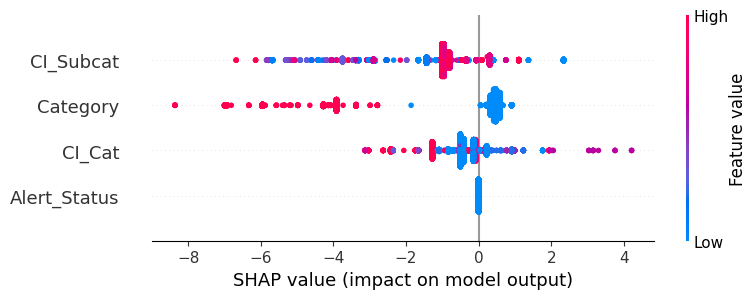

In [ ]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test)

Feature importance ananlysis showed that the subcategory(`Cl_Subcat`) is the most influential predictor of high-priority incidents, contributing approximately 53% of the model's decision-making. It was follwed by `Category` and `Cl_cat`, indicating that type of system and nature of the incident play a major role in escalating risk.

The above summary plot of SHAP further revelaed that specific `Cl_Subcat` consistently increased the chances of high-priority classification, while others reduced it. Alert status showed negligible influence when evaluated alongside other features.

# Use Case - 2

### Statement: **Forecast the incident volume in different fields , quarterly and annual. So that they can be better prepared with resources and technology planning.**

In [ ]:
# creating a copy
df_uc2 = df.copy()

In [ ]:
df_uc2['Open_Time'].isna().sum()

np.int64(0)

In [ ]:
df_uc2['Open_Month'] = df_uc2['Open_Time'].dt.to_period('M')

monthly_incident = (df_uc2.groupby('Open_Month').size().reset_index(name='Incident_Count'))
monthly_incident["Open_Month"] = (monthly_incident["Open_Month"].dt.to_timestamp())

monthly_incident.head()

,Open_Month,Incident_Count
0,2012-02-01,1
1,2012-03-01,2
2,2012-07-01,1
3,2012-08-01,5
4,2012-09-01,2


In [ ]:
monthly_incident

,Open_Month,Incident_Count
0,2012-02-01,1
1,2012-03-01,2
2,2012-07-01,1
3,2012-08-01,5
4,2012-09-01,2
5,2012-10-01,5
6,2012-11-01,1
7,2012-12-01,4
8,2013-01-01,5
9,2013-02-01,10


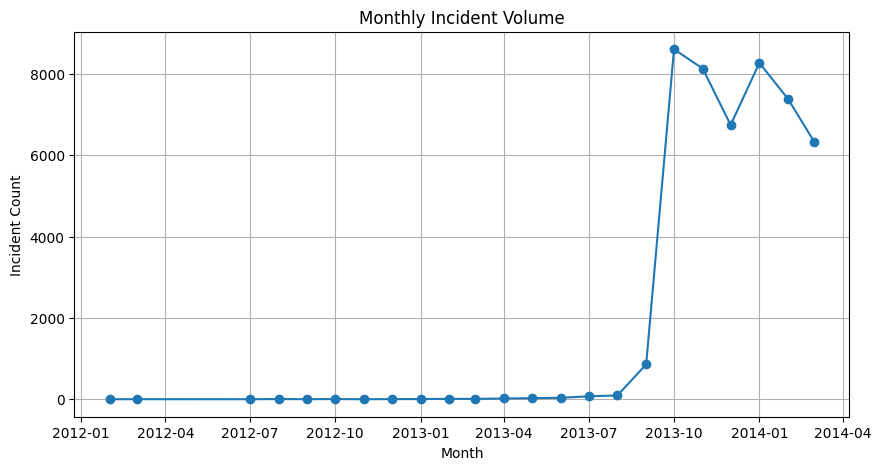

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(
    monthly_incident["Open_Month"],
    monthly_incident["Incident_Count"],
    marker="o"
)
plt.title("Monthly Incident Volume")
plt.xlabel("Month")
plt.ylabel("Incident Count")
plt.grid(True)
plt.show()

As we can see from the plot above, that there is a sudden spike, so we need to use only post-stabilization data for time series forecasting for ensure meaningful forecasting.

### Creating a post-stabilization dataset

In [ ]:
# from 2013-09-01 the sudden spike started
monthly_incident_stable = monthly_incident[monthly_incident["Open_Month"] >= "2013-09-01"].copy()

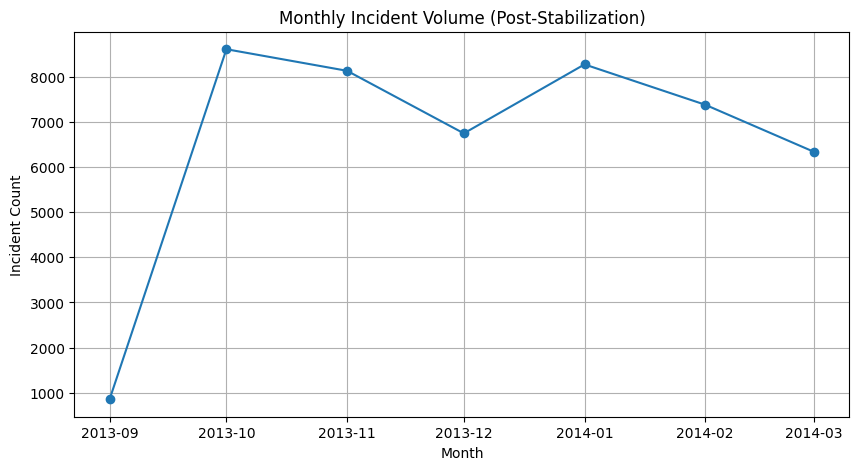

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(
    monthly_incident_stable["Open_Month"],
    monthly_incident_stable["Incident_Count"],
    marker="o"
)
plt.title("Monthly Incident Volume (Post-Stabilization)")
plt.xlabel("Month")
plt.ylabel("Incident Count")
plt.grid(True)
plt.show()

### Baseline smoothing (Moving Average)

In [ ]:
monthly_incident_stable["MA_3"] = (monthly_incident_stable["Incident_Count"].rolling(window=3).mean())

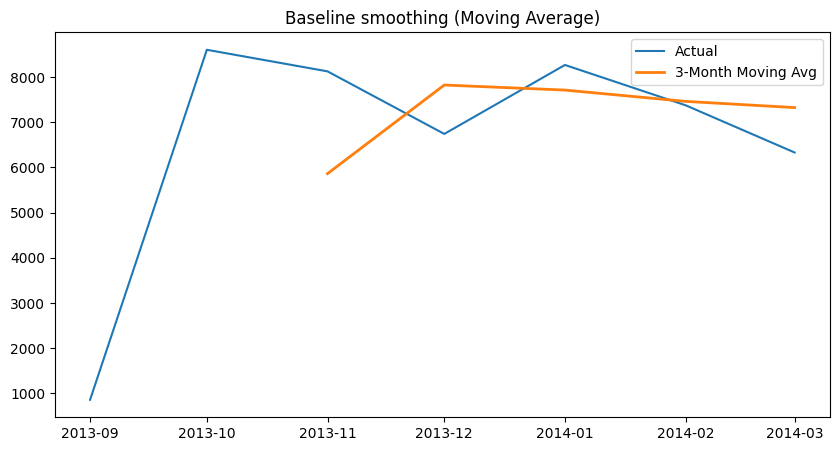

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(
    monthly_incident_stable["Open_Month"],
    monthly_incident_stable["Incident_Count"],
    label="Actual"
)
plt.plot(
    monthly_incident_stable["Open_Month"],
    monthly_incident_stable["MA_3"],
    label="3-Month Moving Avg",
    linewidth=2
)

plt.title("Baseline smoothing (Moving Average)")
plt.legend()
plt.show()


Baseline smoothing(3-month moving average) was used to reduce month-to-month fluctuations while preserving the overall trend. The above resulting plot reveals a sharp increase in incident volume after which the incident counts fluctuats in a relatively stable range.

### ARIMA forecasting (main model)

In [ ]:
ts = (monthly_incident_stable.set_index("Open_Month")["Incident_Count"])

train = ts.iloc[:-3]
test = ts.iloc[-3:] # use last 3 month as test set

In [ ]:
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

In [ ]:
forecast = model_fit.forecast(steps=len(test))
forecast

,predicted_mean
2014-01-01,7446.008047
2014-02-01,6936.407833
2014-03-01,7305.809548


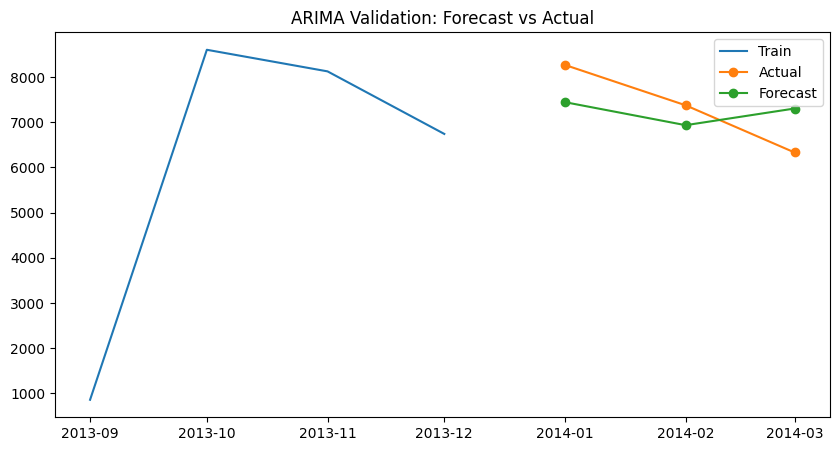

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train, label="Train")
plt.plot(test, label="Actual", marker="o")
plt.plot(forecast, label="Forecast", marker="o")
plt.legend()
plt.title("ARIMA Validation: Forecast vs Actual")
plt.show()

In [ ]:
mae = mean_absolute_error(test, forecast)
print(mae)

746.1312223901645


### Forecasting on full-data (No post-stabilization)

In [ ]:
ts_all = (monthly_incident.set_index("Open_Month")["Incident_Count"])

train_all = ts_all.iloc[:-3]
test_all = ts_all.iloc[-3:]

model_all = ARIMA(train_all, order=(1, 1, 1))
model_fit_all = model_all.fit()

forecast_all = model_fit_all.forecast(steps=len(test_all))

In [ ]:
forecast_all

,predicted_mean
20,7138.962405
21,6866.729287
22,7053.895719


In [ ]:
forecast_all.index = test_all.index

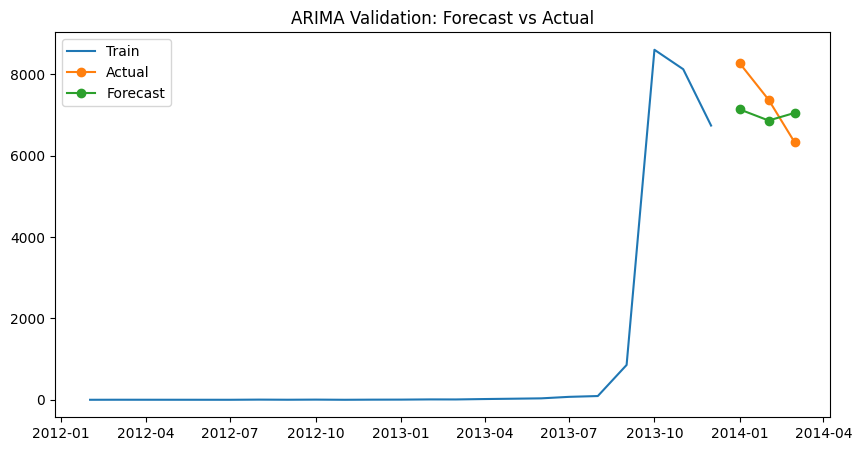

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_all, label="Train")
plt.plot(test_all, label="Actual", marker="o")
plt.plot(forecast_all, label="Forecast", marker="o")
plt.legend()
plt.title("ARIMA Validation: Forecast vs Actual")
plt.show()

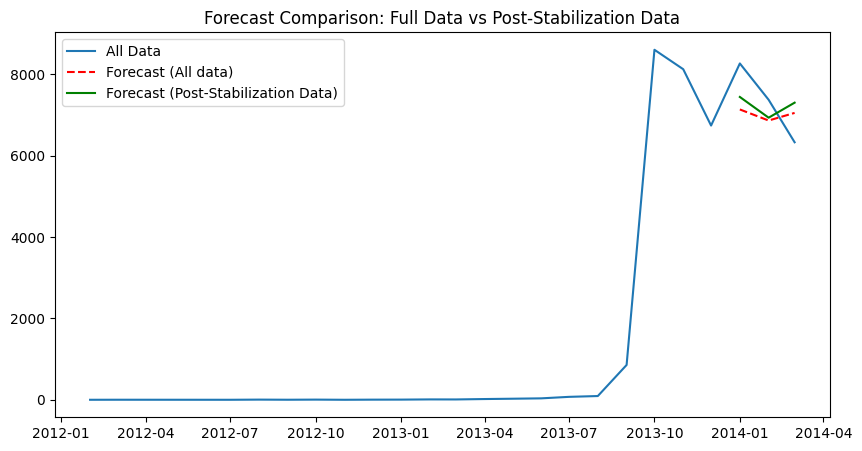

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(ts_all, label="All Data")
plt.plot(
    forecast_all.index,
    forecast_all,
    label="Forecast (All data)",
    linestyle="--",
    color="red"
)

plt.plot(
    forecast.index,
    forecast,
    label="Forecast (Post-Stabilization Data)",
    linestyle="-",
    color="green"
)

plt.legend()
plt.title("Forecast Comparison: Full Data vs Post-Stabilization Data")
plt.show()

For comparison purposes, a forecasting model was also trained on the complete historical dataset, including periods before and after September 2013.

### Validation of Forecasting Model
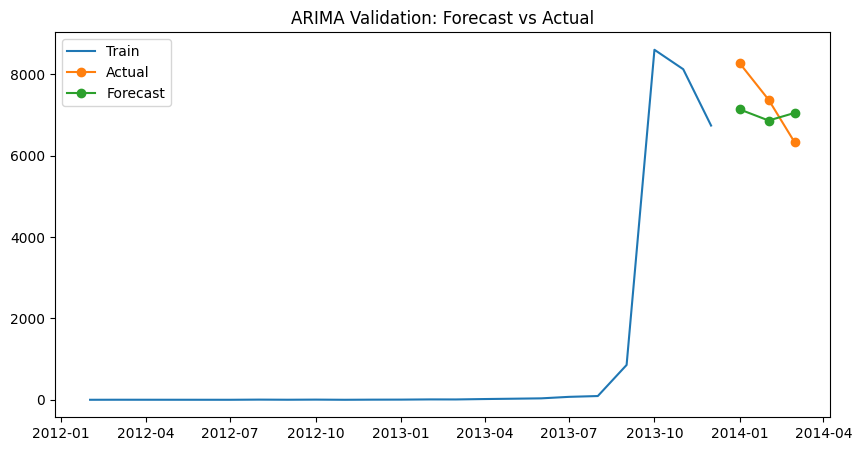

The ARIMA model was validated using a time-aware train-test split, with the most recent three months reserved for testing. Visual comparison between predicted and actual incident volumes shows that the model captures both the direction and magnitude of recent trends. The mean absolute error of approximately 746 incidents corresponds to about 10% of average monthly volume, which is acceptable for capacity planning and operational forecasting.

---
### Effect of Structural Break on Forecasting

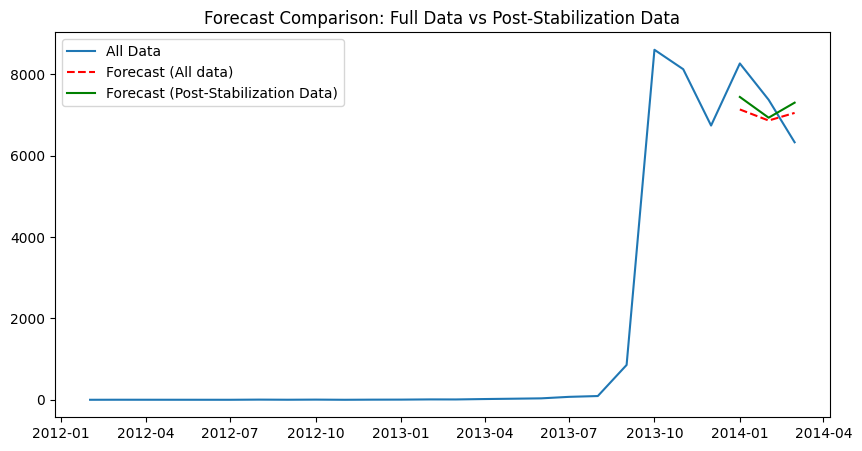

A comparison model trained on the complete historical dataset produced forecasts biased toward lower incident volumes due to the influence of early low-coverage data. This shows that including pre-stabilization periods distorts future predictions. Therefore, only post-stabilization data was used for final forecasting to ensure reliable and operationally meaningful results.

This use case aims to forecast incident volumes over time to support quarterly and annual resource planning. In this project, incident creation timestamps were aggregated at a monthly level and modeled using time-series forecasting techniques. Monthly forecasts were then used as the basis for deriving quarterly and annual incident volume estimates. These forecasts provide actionable inputs for workforce planning, infrastructure provisioning, and technology capacity management.

# Use Case - 3

### Statement: **Auto tag the tickets with right priorities and right departments so that reassigning and related delay can be reduced**

Since we've already assigned right priorities in the Case-1 so we'll predict the correct departments here.

In [ ]:
# creating a copy
df_uc3 = df.copy()

In [ ]:
df_uc3.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'No_of_Related_Incidents',
       'No_of_Related_Changes', 'Related_Interaction_Is_Multi',
       'Related_Change_Is_Multi', 'Handle_Time_is_multi',
       'Handle_Time_hrs_missing', 'Is_Resolved', 'Was_Reopened', 'Is_Closed',
       'Has_Related_Interaction', 'Has_Related_Change'],
      dtype='object')

Here our target column is `WBS` and input columns are `CI_Cat, CI_Subcat Impact, Urgency, Alert_Status`

In [ ]:
df_uc3[['CI_Cat','CI_Subcat', 'Impact', 'Urgency', 'Alert_Status', 'WBS']].isna().sum()

,0
CI_Cat,0
CI_Subcat,0
Impact,1380
Urgency,1
Alert_Status,0
WBS,0


In [ ]:
df_uc3 = df_uc3[df_uc3['Impact'].notna() & df_uc3['Urgency'].notna()].copy()

In [ ]:
df_uc3[['CI_Cat','CI_Subcat', 'Impact', 'Urgency', 'Alert_Status', 'WBS']].isna().sum()

,0
CI_Cat,0
CI_Subcat,0
Impact,0
Urgency,0
Alert_Status,0
WBS,0


In [ ]:
df_uc3['WBS'].value_counts()

,count
WBS,
WBS000073,13292
WBS000091,2439
WBS000263,2277
WBS000072,2190
WBS000271,1182
...,...
WBS000001,1
WBS000004,1
WBS000207,1


We can see that there are lots of WBS codes so we'll keep departments with at least 200 tickets.

In [ ]:
count_200 = df_uc3['WBS'].value_counts()
common_wbs_200 = count_200[count_200 >= 200].index

In [ ]:
common_wbs_200

Index(['WBS000073', 'WBS000091', 'WBS000263', 'WBS000072', 'WBS000271',
       'WBS000095', 'WBS000152', 'WBS000318', 'WBS000094', 'WBS000146',
       'WBS000223', 'WBS000092', 'WBS000128', 'WBS000088', 'WBS000099',
       'WBS000228', 'WBS000292', 'WBS000089', 'WBS000296', 'WBS000162',
       'WBS000219', 'WBS000096', 'WBS000016', 'WBS000199', 'WBS000187',
       'WBS000172', 'WBS000307', 'WBS000125', 'WBS000255', 'WBS000023',
       'WBS000110', 'WBS000013', 'WBS000264', 'WBS000330', 'WBS000043',
       'WBS000093', 'WBS000025', 'WBS000098', 'WBS000015'],
      dtype='object', name='WBS')

In [ ]:
df_uc3 = df_uc3[df_uc3['WBS'].isin(common_wbs_200)].copy()

In [ ]:
df_uc3.shape

(38033, 32)

In [ ]:
x = df_uc3[["CI_Cat", "CI_Subcat", "Category", "Impact", "Urgency", "Alert_Status"]]
y = df_uc3["WBS"]

In [ ]:
encoders = {}

for col in ["CI_Cat", "CI_Subcat", "Category", "Alert_Status"]:
  le = LabelEncoder()
  x[col] = le.fit_transform(x[col])
  encoders[col] = le

le_traget = LabelEncoder()
y_enc = le_traget.fit_transform(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

In [ ]:
cat_uc3 = CatBoostClassifier(iterations=500, depth=8, learning_rate=0.1, loss_function="MultiClass", random_state=42, verbose=0)
cat_uc3.fit(x_train, y_train)

In [ ]:
y_pred = cat_uc3.predict(x_test)

print("Top-1 Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Top-1 Accuracy: 0.6487445773629552
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.00      0.00      0.00        41
           2       0.33      0.01      0.02        81
           3       1.00      0.30      0.46        50
           4       0.40      0.93      0.55        41
           5       0.00      0.00      0.00        42
           6       0.48      0.95      0.64       438
           7       0.71      0.92      0.80      2658
           8       0.40      0.05      0.09       122
           9       0.85      0.10      0.17       113
          10       0.86      0.92      0.89       488
          11       0.31      0.85      0.45       150
          12       0.00      0.00      0.00        42
          13       0.69      0.90      0.78       172
          14       0.93      1.00      0.96       220
          15       1.00      0.16      0.27        82
          16       0.61      0.66      0.64   

In [ ]:
y_proba = cat_uc3.predict_proba(x_test)

top3_preds = np.argsort(y_proba, axis=1)[:, -3:]

top3_correct = [
    y_test[i] in top3_preds[i]
    for i in range(len(y_test))
]

top3_accuracy = np.mean(top3_correct)
print("Top-3 Accuracy: ", top3_accuracy)

Top-3 Accuracy:  0.8837912449060076


Now we'll keep departments with atleast 500 tickets

In [ ]:
count_500 = df_uc3['WBS'].value_counts()
common_wbs_500 = count_500[count_500 >= 500].index

In [ ]:
df_uc3 = df_uc3[df_uc3['WBS'].isin(common_wbs_500)].copy()

In [ ]:
x = df_uc3[["CI_Cat", "CI_Subcat", "Category", "Impact", "Urgency", "Alert_Status"]]
y = df_uc3["WBS"]

In [ ]:
encoders = {}

for col in ["CI_Cat", "CI_Subcat", "Category", "Alert_Status"]:
  le = LabelEncoder()
  x[col] = le.fit_transform(x[col])
  encoders[col] = le

le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

In [ ]:
cat_uc3 = CatBoostClassifier(iterations=500, depth=8, learning_rate=0.1, loss_function="MultiClass", random_state=42, verbose=0)
cat_uc3.fit(x_train, y_train)

In [ ]:
y_pred = cat_uc3.predict(x_test)

print("Top-1 Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Top-1 Accuracy: 0.7530364372469636
              precision    recall  f1-score   support

           0       0.54      0.97      0.70       438
           1       0.76      0.95      0.85      2658
           2       0.33      0.02      0.03       122
           3       0.83      0.09      0.16       113
           4       1.00      0.93      0.96       488
           5       0.46      0.85      0.60       150
           6       0.83      0.90      0.86       172
           7       1.00      1.00      1.00       220
           8       0.66      0.61      0.64       122
           9       1.00      0.63      0.77       149
          10       1.00      1.00      1.00       165
          11       0.47      0.82      0.60       215
          12       0.00      0.00      0.00       160
          13       0.00      0.00      0.00       120
          14       0.00      0.00      0.00       455
          15       0.99      1.00      1.00       236
          16       1.00      1.00      1.00   

In [ ]:
y_proba = cat_uc3.predict_proba(x_test)

top3_preds = np.argsort(y_proba, axis=1)[:, -3:]

top3_correct = [
    y_test[i] in top3_preds[i]
    for i in range(len(y_test))
]

top3_accuracy = np.mean(top3_correct)
print("Top-3 Accuracy: ", top3_accuracy)

Top-3 Accuracy:  0.9641856119588913


As we can see above model with departments with atleast 500 tickets performed really well, this ensure reliable learning. This reduced class sparsity and focused the model on departments with high ticket count with the greatest business impact.

Top-1 Accuracy(~ 75%): Out of 100 tickets, the model directly route **75 tickets** to the correct department.

Top-3 Accuracy(~ 96%): Out of 100 tickets, the correct department is present in the **top 3 suggestions for about 96 tickets**.

Thats why we're choosing top-3 accuracy, because it demonstrates strong practical utility for **reducing reassignments** and **routing delays**.

### Business Impact Analysis of Auto-Tagging Model

In [ ]:
df_test = x_test.copy()

df_test["True_WBS"] = le_target.inverse_transform(y_test)
df_test["Pred_WBS"] = le_target.inverse_transform(y_pred)

df_test["No_of_Reassignments"] = df_uc3.loc[df_test.index, "No_of_Reassignments"]
df_test["Handle_Time_hrs"] = df_uc3.loc[df_test.index, "Handle_Time_hrs"]

In [ ]:
df_test

,CI_Cat,CI_Subcat,Category,Impact,Urgency,Alert_Status,True_WBS,Pred_WBS,No_of_Reassignments,Handle_Time_hrs
28625,7,1,1,4.0,4.0,0,WBS000292,WBS000292,2.0,396.000000
31868,0,16,3,5.0,5.0,0,WBS000072,WBS000072,2.0,460.000000
3813,0,16,3,5.0,5.0,0,WBS000263,WBS000072,0.0,0.700833
43033,0,16,3,5.0,5.0,0,WBS000072,WBS000072,2.0,0.403889
22768,0,16,3,5.0,5.0,0,WBS000072,WBS000072,2.0,228.000000
...,...,...,...,...,...,...,...,...,...,...
34549,0,20,1,4.0,4.0,0,WBS000073,WBS000073,0.0,14.225000
9145,0,15,3,5.0,5.0,0,WBS000271,WBS000271,1.0,553.000000
20553,0,16,3,5.0,5.0,0,WBS000072,WBS000072,0.0,0.091944
25778,0,16,3,5.0,5.0,0,WBS000296,WBS000072,0.0,448.000000


In [ ]:
correct = df_test[df_test["True_WBS"] == df_test["Pred_WBS"]]
incorrect = df_test[df_test["True_WBS"] != df_test["Pred_WBS"]]

correct_stats = correct[["No_of_Reassignments", "Handle_Time_hrs"]].mean()
incorrect_stats = incorrect[["No_of_Reassignments", "Handle_Time_hrs"]].mean()

correct_stats, incorrect_stats

(No_of_Reassignments      1.003515
 Handle_Time_hrs        427.633732
 dtype: float64,
 No_of_Reassignments      1.767970
 Handle_Time_hrs        506.513773
 dtype: float64)

To evaluate the operational effectiveness of the auto-tagging model, post-routing outcome metrics were analyzed. Tickets were divided into two groups: those routed to the correct department by the model and those routed incorrectly. For each group, the average number of reassignments and average handling time were computed.

| Routing Outcome   | Avg. Reassignments | Avg. Handle Time (hrs) |
| ----------------- | ------------------ | ---------------------- |
| Correct Routing   | 1.003515           | 427.633732             |
| Incorrect Routing | 1.767970           | 506.513773             |

The analysis shows that tickets correctly routed by the model experienced significantly fewer reassignments and lower average handling time compared to incorrectly routed tickets. This confirms that accurate initial routing reduces manual reassignment effort and accelerates ticket resolution. These findings demonstrate the practical business value of the proposed auto-tagging system in improving service desk efficiency.

# Use Case-4

### Statement: **Predict RFC (Request for change) and possible failure / misconfiguration of ITSM assets.**

In [ ]:
df_uc4 = df.copy()

In [ ]:
df_uc4.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'No_of_Related_Incidents',
       'No_of_Related_Changes', 'Related_Interaction_Is_Multi',
       'Related_Change_Is_Multi', 'Handle_Time_is_multi',
       'Handle_Time_hrs_missing', 'Is_Resolved', 'Was_Reopened', 'Is_Closed',
       'Has_Related_Interaction', 'Has_Related_Change'],
      dtype='object')

## UC4-A
Statement: **Predict RFC(Request for Change)**

In [ ]:
df_uc4['Has_Related_Change'].value_counts(normalize=True)

,proportion
Has_Related_Change,
0,0.988499
1,0.011501


It's clear that the target feature (`Has_Related_Change`) is highly unbalanced. So we'll focus on **recall** and not **accuracy**.

In [ ]:
features_uc4 = ['CI_Cat', 'CI_Subcat', 'Category', 'Impact', 'Urgency', 'Alert_Status']
target_feature = 'Has_Related_Change'

# storing only those features which are not null
df_uc4 = df_uc4[df_uc4[features_uc4].notna().all(axis=1)].copy()

x = df_uc4[features_uc4]
y = df_uc4[target_feature]

In [ ]:
encoders = {}

for col in features_uc4:
  le = LabelEncoder()
  x[col] = le.fit_transform(x[col])
  encoders[col] = le

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### Baseline Model

In [ ]:
lr = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42, class_weight='balanced')
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)

In [ ]:
y_pred_proba_lr = lr.predict_proba(x_test)[:, 1]
print("ROC(LR): ", roc_auc_score(y_test, y_pred_proba_lr))
print(classification_report(y_test, lr.predict(x_test)))

ROC(LR):  0.6343392956959195
              precision    recall  f1-score   support

           0       0.99      0.47      0.64      8945
           1       0.01      0.69      0.03       100

    accuracy                           0.47      9045
   macro avg       0.50      0.58      0.33      9045
weighted avg       0.98      0.47      0.63      9045



### Strong Model

In [ ]:
cat = CatBoostClassifier(iterations=500, depth=8, learning_rate=0.1, eval_metric="AUC", auto_class_weights="Balanced", random_state=42, verbose=0)
cat.fit(x_train, y_train)

In [ ]:
y_pred_proba_cat = cat.predict_proba(x_test)[:, 1]
print("ROC(catBoost):", roc_auc_score(y_test, y_pred_proba_cat))
print(classification_report(y_test, cat.predict(x_test)))

ROC(catBoost): 0.744503633314701
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      8945
           1       0.03      0.62      0.05       100

    accuracy                           0.76      9045
   macro avg       0.51      0.69      0.46      9045
weighted avg       0.98      0.76      0.85      9045



As we can see, CatBoost clearly performed really well, we got an roc value of around 0.75 with catboost and recall and precision are also good for the minority class in CatBoost.

Now we'll threshold tune the CatBoost to check if we can improve it further

In [ ]:
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
threshold_results = []

for t in thresholds:
  y_pred_t = (y_pred_proba_cat >= t).astype(int)
  report = classification_report(y_test, y_pred_t, output_dict=True)

  threshold_results.append({
      "Threshold": t,
      "Precision_1": report['1']['precision'],
      "Recall_1": report['1']['recall'],
      "f1-score_1": report['1']['f1-score'],
      "Accuracy": report['accuracy']
  })

threshold_results = pd.DataFrame(threshold_results)
threshold_results

,Threshold,Precision_1,Recall_1,f1-score_1,Accuracy
0,0.01,0.012891,0.99,0.025450,0.161747
1,0.02,0.012849,0.98,0.025366,0.167385
2,0.05,0.012628,0.96,0.024929,0.169707
3,0.10,0.012637,0.96,0.024945,0.170260
4,0.20,0.015251,0.93,0.030010,0.335323
5,0.25,0.015253,0.93,0.030015,0.335434
6,0.30,0.015071,0.91,0.029651,0.341515
7,0.35,0.015177,0.91,0.029856,0.346158
8,0.40,0.015434,0.91,0.030354,0.357214
9,0.50,0.027716,0.62,0.053059,0.755334


In [ ]:
THRESHOLD_UC4_A = 0.4

Due to severe class imbalance, the default threshold of 0.5 is not suitable for this case, just like Use Case 1, so we tuned the threshold and found that 0.4 is the best suited for this case, as well, because it achieved 91% recall for RFC cases while reducing unnecessary alerts.

This threshold provides an effective balance between early detection and operational feasibility.

## UC4-B
Statement: **Predict high-risk / misconfiguration-prone ITSM assets**

In [ ]:
df_uc4['CI_Name'].value_counts()

,count
CI_Name,
SUB000456,3042
SBA000263,2169
SBA000607,1737
SBA000462,1693
WBA000058,1613
...,...
CBD000654,1
RTR000014,1
LAP001514,1


In [ ]:
df_uc4.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'No_of_Related_Incidents',
       'No_of_Related_Changes', 'Related_Interaction_Is_Multi',
       'Related_Change_Is_Multi', 'Handle_Time_is_multi',
       'Handle_Time_hrs_missing', 'Is_Resolved', 'Was_Reopened', 'Is_Closed',
       'Has_Related_Interaction', 'Has_Related_Change'],
      dtype='object')

In [ ]:
df_uc4.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Related_Interaction_Is_Multi,Related_Change_Is_Multi,Handle_Time_is_multi,Handle_Time_hrs_missing,Is_Resolved,Was_Reopened,Is_Closed,Has_Related_Interaction,Has_Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4.0,4.0,4.0,0.601292,incident,KM0000553,closed,26.0,2012-02-05 13:32:00,NaT,2013-11-04 13:50:00,2013-11-04 13:51:00,308.0,Other,1.0,2.0,0.0,0,0,1,0,1,0,1,1,0
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3.0,3.0,3.0,0.415050,incident,KM0000611,closed,33.0,2012-03-12 15:44:00,2013-12-02 12:31:00,2013-12-02 12:36:00,2013-12-02 12:36:00,561.0,Software,1.0,1.0,0.0,0,0,1,0,1,1,1,1,0
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4.0,4.0,4.0,0.642927,incident,KM0000611,closed,13.0,2012-07-17 11:49:00,NaT,2013-11-14 09:31:00,2013-11-14 09:31:00,420.0,Operator error,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4.0,4.0,4.0,0.345258,incident,KM0000611,closed,2.0,2012-08-10 11:01:00,NaT,2013-11-08 13:55:00,2013-11-08 13:55:00,416.0,Other,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0
5,WBA000124,application,Web Based Application,WBS000088,IM0000013,Closed,4.0,4.0,4.0,0.006676,incident,KM0000611,closed,4.0,2012-08-10 11:27:00,NaT,2013-11-08 13:54:00,2013-11-08 13:54:00,1055.0,Other,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0


In [ ]:
df_uc4[df['CI_Name'] == 'ADB000010']

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Related_Interaction_Is_Multi,Related_Change_Is_Multi,Handle_Time_is_multi,Handle_Time_hrs_missing,Is_Resolved,Was_Reopened,Is_Closed,Has_Related_Interaction,Has_Related_Change
974,ADB000010,database,Database,WBS000239,IM0001071,Closed,3.0,4.0,3.0,0.839752,incident,KM0000283,closed,4.0,2013-09-30 10:15:00,NaT,2013-10-01 16:41:00,2013-10-01 16:42:00,545.000000,Software,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0
1248,ADB000010,database,Database,WBS000239,IM0001348,Closed,4.0,4.0,4.0,0.822654,incident,KM0000283,closed,4.0,2013-10-01 09:38:00,NaT,NaT,2013-10-03 13:48:00,381.000000,Software,1.0,0.0,0.0,0,0,1,0,0,0,1,1,0
1292,ADB000010,database,Database,WBS000239,IM0001392,Closed,3.0,4.0,3.0,0.768388,incident,KM0000283,closed,0.0,2013-10-01 11:44:00,NaT,2013-10-01 11:57:00,2013-10-01 11:57:00,0.215000,User error,1.0,0.0,0.0,0,0,0,0,1,0,1,1,0
1483,ADB000010,database,Database,WBS000239,IM0001586,Closed,3.0,4.0,3.0,0.401853,incident,KM0000283,closed,3.0,2013-10-01 15:00:00,2013-10-01 16:01:00,2013-10-02 13:59:00,2013-10-02 13:59:00,944.000000,Software,2.0,0.0,0.0,1,0,1,0,1,1,1,0,0
3355,ADB000010,database,Database,WBS000239,IM0003475,Closed,3.0,4.0,3.0,0.301969,incident,KM0000283,closed,1.0,2013-10-08 09:04:00,NaT,2013-10-08 13:00:00,2013-10-08 13:00:00,786.000000,Software,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45501,ADB000010,database,Database,WBS000239,IM0045931,Closed,3.0,3.0,3.0,0.004591,incident,KM0000940,closed,0.0,2014-03-25 12:15:00,NaT,2014-03-25 13:54:00,2014-03-25 13:54:00,681.000000,User error,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0
45664,ADB000010,database,Database,WBS000239,IM0046098,Closed,3.0,3.0,3.0,0.119729,incident,KM0000940,closed,0.0,2014-03-26 08:48:00,NaT,2014-03-26 12:28:00,2014-03-26 12:28:00,893.000000,User error,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0
45891,ADB000010,database,Database,WBS000239,IM0046327,Closed,3.0,3.0,3.0,0.916828,incident,KM0000940,closed,0.0,2014-03-26 15:45:00,NaT,2014-03-26 16:29:00,2014-03-26 16:29:00,0.741944,User error,1.0,0.0,0.0,0,0,0,0,1,0,1,1,0
46433,ADB000010,database,Database,WBS000239,IM0046882,Closed,3.0,3.0,3.0,0.531294,incident,KM0000940,closed,0.0,2014-03-31 09:53:00,NaT,2014-03-31 11:18:00,2014-03-31 11:18:00,333.000000,User error,1.0,0.0,0.0,0,0,1,0,1,0,1,1,0


In [ ]:
# Grouping and storing the historical behavior of each CI_Name
ci_risk = (
    df_uc4.groupby('CI_Name').agg(
        Incident_count = ('Incident_ID', 'count'),
        RFC_Count = ('Has_Related_Change', 'sum'),
        Avg_Handle_Time = ('Handle_Time_hrs', 'mean'),
        Avg_Reassignments = ('No_of_Reassignments', 'mean')
    ).reset_index()
)

ci_risk

,CI_Name,Incident_count,RFC_Count,Avg_Handle_Time,Avg_Reassignments
0,ACS000001,1,0,705.000000,3.000000
1,ADB000005,1,0,0.148889,0.000000
2,ADB000010,130,0,393.528021,0.792308
3,ADB000021,1,0,0.435556,0.000000
4,ADB000023,1,0,749.000000,2.000000
...,...,...,...,...,...
2923,ZOC000002,6,0,2.438565,0.000000
2924,ZOC000004,7,0,370.910159,0.428571
2925,ZOC000005,1,0,0.798889,0.000000
2926,ZOS000006,1,0,1.380000,0.000000


In [ ]:
# Standardize
minmax = MinMaxScaler()

risk_features = [
    'Incident_count',
    'RFC_Count',
    'Avg_Handle_Time',
    'Avg_Reassignments'
]

ci_risk_scaled = ci_risk.copy()

ci_risk_scaled[risk_features] = minmax.fit_transform(ci_risk[risk_features])

In [ ]:
ci_risk_scaled

,CI_Name,Incident_count,RFC_Count,Avg_Handle_Time,Avg_Reassignments
0,ACS000001,0.000000,0.0,0.607235,0.142857
1,ADB000005,0.000000,0.0,0.000128,0.000000
2,ADB000010,0.042420,0.0,0.338956,0.037729
3,ADB000021,0.000000,0.0,0.000375,0.000000
4,ADB000023,0.000000,0.0,0.645134,0.095238
...,...,...,...,...,...
2923,ZOC000002,0.001644,0.0,0.002100,0.000000
2924,ZOC000004,0.001973,0.0,0.319475,0.020408
2925,ZOC000005,0.000000,0.0,0.000688,0.000000
2926,ZOS000006,0.000000,0.0,0.001189,0.000000


In [ ]:
ci_risk_scaled['Risk_Score'] = (
    0.35 * ci_risk_scaled['Incident_count'] +
    0.35 * ci_risk_scaled['RFC_Count'] +
    0.2 * ci_risk_scaled['Avg_Handle_Time'] +
    0.1 * ci_risk_scaled['Avg_Reassignments']
)

ci_risk_scaled

,CI_Name,Incident_count,RFC_Count,Avg_Handle_Time,Avg_Reassignments,Risk_Score
0,ACS000001,0.000000,0.0,0.607235,0.142857,0.135733
1,ADB000005,0.000000,0.0,0.000128,0.000000,0.000026
2,ADB000010,0.042420,0.0,0.338956,0.037729,0.086411
3,ADB000021,0.000000,0.0,0.000375,0.000000,0.000075
4,ADB000023,0.000000,0.0,0.645134,0.095238,0.138551
...,...,...,...,...,...,...
2923,ZOC000002,0.001644,0.0,0.002100,0.000000,0.000996
2924,ZOC000004,0.001973,0.0,0.319475,0.020408,0.066626
2925,ZOC000005,0.000000,0.0,0.000688,0.000000,0.000138
2926,ZOS000006,0.000000,0.0,0.001189,0.000000,0.000238


A aggregrate asset risk score was defined by combining multiple normalized features, including incident frequency, number of RFCs, average handling time and average number of reassignments. The weights were chosen according to business relevance, with higher importance were given to incident frequency and number of RFCs.

We can always change the weights according to the business requirements.

In [ ]:
# saving top 10 high-risk assets
high_risk_assets = (
    ci_risk_scaled.sort_values("Risk_Score", ascending=False).head(10)
)

high_risk_assets

,CI_Name,Incident_count,RFC_Count,Avg_Handle_Time,Avg_Reassignments,Risk_Score
2657,SUB000456,1.000000,0.622951,0.268460,0.019379,0.623663
2757,WBA000058,0.530089,1.000000,0.275123,0.020193,0.592575
2395,SBA000462,0.556396,0.475410,0.345569,0.035637,0.433810
2428,SBA000607,0.570865,0.131148,0.481867,0.154755,0.357553
2317,SBA000263,0.712923,0.016393,0.373701,0.092582,0.339259
982,DTA000056,0.064124,0.655738,0.404959,0.025267,0.335470
2786,WBA000124,0.199277,0.262295,0.516334,0.171648,0.281982
2741,WBA000011,0.309767,0.245902,0.406424,0.060344,0.281803
2792,WBA000133,0.475830,0.016393,0.440918,0.059063,0.266368
978,DTA000049,0.000000,0.000000,0.910422,0.714286,0.253513


Using the composite risk score, assets were ranked to identify most prone to misconfigurations. Assets with high incident and RFC counts are likely misconfigured or structurally unstable, while assets with high handling time and reassignments indicate complex or poorly documented systems. These assets should be prioritized for preventive maintenance, configuration review, and monitoring enhancements.

# Conclusion

This project developed an end-to-end ITSM analytics framework to improve incident prioritization, capacity planning, ticket routing, and change management. Machine learning and data-driven analysis were applied across four use cases to enhance operational efficiency and service quality.

Priority prediction enabled early identification of critical incidents, forecasting supported resource planning, auto-tagging reduced reassignment delays, and RFC prediction combined with asset risk analysis facilitated preventive maintenance and change planning. Together, these use cases demonstrate the practical application of analytics in real-world IT service management.

# Future Scope


* We can implement NLP to analyze ticket text.
* Real-time model deployment integrated with ITSM tools.
* Continuous learning using feedback from resolved tickets.
* Dynamic threshold handling based on business requirements.

